# Importing libraries

In [1]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

from utils.metrics import *

%config Completer.use_jedi = False

/usr/local/lib/python3.6/dist-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Specifying trained model and data

In [2]:
EXP_NAME = '2022-03-18_experiment_a7431019-46fe-478c-83a5-ef394784f7fa'

with open(f'experiments/{EXP_NAME}/config.json') as json_file:
    config = json.load(json_file)

config = edict(config)
config.subjects = list(set(config.subjects))

os.makedirs(f'experiments/{config.name_of_experiment}/metrics', exist_ok=True)
os.makedirs(f'experiments/{config.name_of_experiment}/top_10_masks', exist_ok=True)

In [3]:
data_dict = {}
for subject in config.subjects:
    
    prediction_path = f"experiments/{config.name_of_experiment}/interpolation/{subject}.nii.gz" 
    label_path = f"{config.path_to_data}/labels/{subject}.nii.gz" 

    data_dict[subject] = [prediction_path, label_path]

# Calculation of metrics

In [5]:
CROP_SIZE = 64
NUMBER_OF_TOP_CROPS = 10

for subject in tqdm(config.subjects):
    
    get_overview_df_for_metric(
        prediction_path=data_dict[subject][0],
        label_path=data_dict[subject][1],
        crop_size=CROP_SIZE,
        number_of_top_crops=NUMBER_OF_TOP_CROPS,
        folder_to_save=f'experiments/{config.name_of_experiment}/metrics',
        name_to_save=subject,
    )

100%|██████████| 131/131 [18:42<00:00,  8.57s/it]


100%|██████████| 130/130 [00:00<00:00, 266.14it/s]


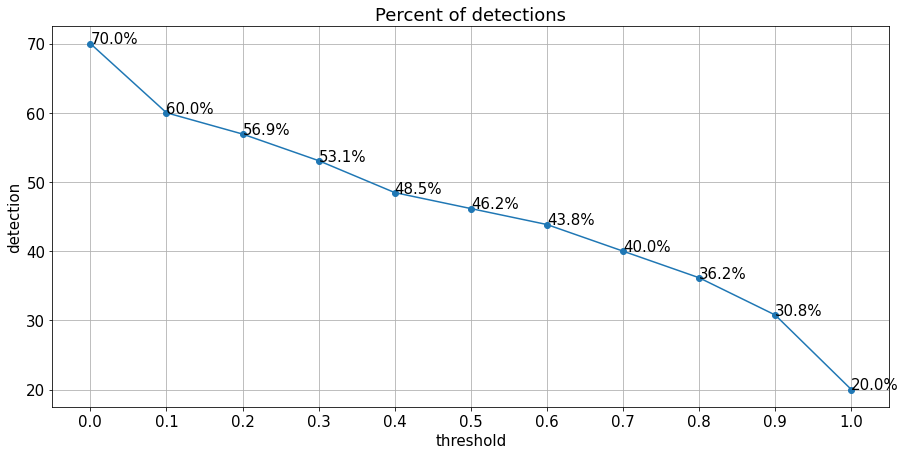

In [22]:
df_metric = pd.DataFrame(columns=['subject', 'x', 'y', 'z', 'average_prediction', 'label_size', 'intersection_size'])

for subject in tqdm(config.subjects):
    brain_metric_df = pd.read_csv(f'experiments/{config.name_of_experiment}/metrics/{subject}.csv', index_col=0)
    brain_metric_df['subject'] = subject
    
    df_metric = pd.concat([df_metric, brain_metric_df], ignore_index=True) 
    
detections = []
for th in np.linspace(1e-8, 1, 11):
    detections.append((df_metric.groupby('subject').intersection_size.max() >= df_metric.groupby('subject').label_size.max()*th).sum())
    
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(np.linspace(0, 1, 11), [x/len(config.subjects)*100 for x in detections], '-o')
plt.xticks(np.linspace(0, 1, 11))
plt.xlabel('threshold')
plt.ylabel('detection')
plt.grid(True)

for a,b in zip(np.linspace(0, 1, 11), detections): 
    plt.text(a, b/len(config.subjects)*100, str(np.round((b/len(config.subjects)*100), decimals=1))+'%')
plt.title('Percent of detections')
plt.savefig(f'experiments/{config.name_of_experiment}/vb_metric_treshold.png', bbox_inches='tight', pad_inches=0)

In [12]:
df_sorted_metric = pd.DataFrame(columns=['subject'], data=config.subjects)
df_sorted_metric['rating'] = None
for th, rating in zip(np.linspace(1e-8, 1, 11), np.linspace(0,1,11)):
    
    th_detection_df = pd.DataFrame(columns=['detection'], data=df_metric.groupby('subject').intersection_size.max() >= df_metric.groupby('subject').label_size.max()*th)
    th_detection_df.reset_index(inplace=True)
    subjects = th_detection_df[th_detection_df.detection == True].subject.tolist()
    
    idxs = df_sorted_metric[df_sorted_metric.subject.isin(subjects)].index 
    df_sorted_metric.loc[idxs, 'rating'] = rating

df_sorted_metric.sort_values(by=['rating'], ascending=False, inplace=True)
df_sorted_metric.to_csv(f'experiments/{config.name_of_experiment}/metrics/rating_of_brains.csv')

In [25]:
for subject in tqdm(config.subjects):
    
    original_brain = nib.load(f"{config.path_to_data}/{config.brains_modality}_brains/{subject}.nii.gz")
    brain_metric_df = pd.read_csv(f'experiments/{config.name_of_experiment}/metrics/{subject}.csv', index_col=0)
    brain_metric_df.reset_index(inplace=True, drop=True)
    
    top_10_mask = np.zeros(original_brain.shape)

    for i in range(9,-1,-1):
        x, y, z = brain_metric_df.loc[i, ['x', 'y', 'z']].astype(int)

        top_10_mask[
                    x: min(x+CROP_SIZE, original_brain.shape[0]),
                    y: min(y+CROP_SIZE, original_brain.shape[1]),
                    z: min(z+CROP_SIZE, original_brain.shape[2])
                ] = 1-i/10

    mask = nib.Nifti1Image(top_10_mask, original_brain.affine)
    nib.save(mask, f"experiments/{config.name_of_experiment}/top_10_masks/{subject}.nii.gz")

100%|██████████| 130/130 [01:02<00:00,  2.09it/s]


# Old metrics

In [4]:
df = pd.DataFrame(columns=['dice', 'iou', 'contrast', 'recall', 'top10', 'min_number_of_crops'])

for subject in tqdm(config.subjects):
    
    prediction_path, label_path = data_dict[subject]
    
    prediction = load_nii_to_array(prediction_path)
    label = load_nii_to_array(label_path)
    
    dice, iou, contrast, recall = compute_metrics_on_voxels(prediction, label)
    top10, min_number_of_crops = get_top_10_metric_and_mask(config, subject, prediction, label, crop_size=64)
    
    df.loc[subject] = [dice, iou, contrast, recall, np.round(top10, decimals=2), min_number_of_crops]
    
df.sort_values(by=['top10', 'contrast'], ascending=False, inplace=True)
df.loc['mean'] = df.mean()
df = df[['contrast', 'recall', 'top10', 'min_number_of_crops', 'dice', 'iou']]
df.to_csv(f'experiments/{EXP_NAME}/vb_metrics.csv')

100%|██████████| 142/142 [04:47<00:00,  2.02s/it]


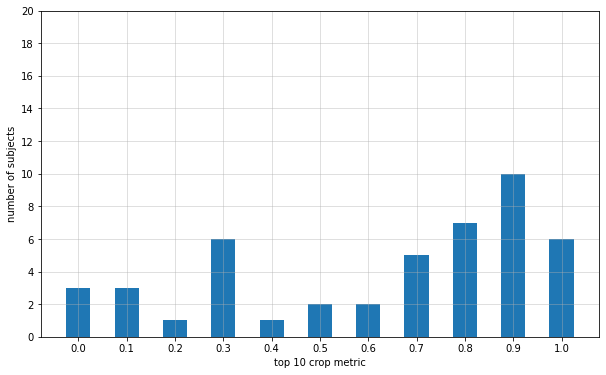

In [5]:
df_metric = pd.DataFrame(df.top10[:-1].value_counts())

fig, axs =  plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})

plt.bar(df_metric.index.tolist(),
        df_metric.top10.tolist(),
        width = 0.05,
       tick_label=df_metric.index.tolist())
plt.grid(True, alpha=0.5)
plt.ylim(0, 20)
plt.ylabel('number of subjects')
plt.yticks(range(0, 22, 2))
plt.xlabel('top 10 crop metric')
plt.savefig(f'experiments/{EXP_NAME}/vb_histogram_top_10_score.jpeg')